In [111]:
### PART 0: SETUP

# Basic packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Scipy packages
from ISLP import confusion_table
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import sklearn.model_selection as skm
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RC
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, 
                                           QuadraticDiscriminantAnalysis as QDA)


# Dataset packages
import torchvision
import torchvision.transforms as transforms

# Torch packages
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset # To extract a subset of thr training data
from torchinfo import summary

In [112]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))]) # The first one corresponds to the mean per channel,
                                           # The second is the std per sample
                                           # (Input - Mean)/Std   [0,1] --> [-1,1]

full_trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True,transform=transform)
testset  = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=transform)

# There will be 10 classes in total
classes = full_trainset.classes
print(classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [113]:
subset_indices = np.arange(1000)
trainset       = Subset(full_trainset, subset_indices)

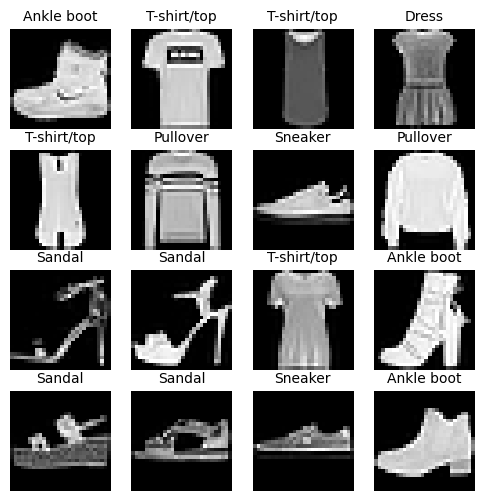

In [114]:
# Plot a few samples to visualize the data

fig,axs = plt.subplots(4,4,figsize=(6,6))
axs = axs.flatten()
for i in range(16):
    img = trainset[i][0].numpy().squeeze()
    axs[i].imshow(img,cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(f"{classes[trainset[i][1]]}",fontsize=10)

In [115]:
X_train_flat = np.array([trainset[i][0].flatten() for i in range(1000)])
Y_train      = np.array([trainset[i][1] for i in range(1000)])
X_test_flat  = np.array([testset[i][0].flatten() for i in range(testset.data.shape[0])])
Y_test       = np.array([testset[i][1] for i in range(testset.data.shape[0])])

In [116]:
print(X_train_flat.shape)
print(Y_train.shape)
print(X_test_flat.shape)
print(Y_test.shape)

(1000, 784)
(1000,)
(10000, 784)
(10000,)


In [117]:
### 0: PRINCIPAL COMPONENTS ANALYSIS

# Apply PCA to training data 
pca = PCA(svd_solver='full') 
pca.fit(X_train_flat)

# Explained variance ratio
var_explained = np.cumsum(pca.explained_variance_ratio_)

# Find number of components to explain > 90% variance
pca_dim = np.argmax(var_explained > 0.90) + 1
print(f"Number of dimensions to explain 90% variance: {pca_dim}")

# Transform data into lower-dimensional space
X_pca_train = pca.transform(X_train_flat)[:, :pca_dim]
print(X_pca_train.shape)  # should be [n_samples, pca_dim]

# Apply the trained PCA to test data
X_pca_test_full = pca.transform(X_test_flat)  # Full PCA transform
X_pca_test = X_pca_test_full[:, :pca_dim]     # Slice to retained dimensions

Number of dimensions to explain 90% variance: 69
(1000, 69)


In [118]:
### CLASS-WISE ACCURACY FUNCTION

def acc_table(pred_labels,true_labels,print_class_accuracy = True):
    tab = np.array(confusion_table(true_labels,pred_labels))
    n_samples = true_labels.size

    total_acc = 0.0;
    class_acc = np.zeros(len(classes))
    for i,cn in enumerate(classes):
        class_acc[i] = float(tab[i,i])/float(sum(tab[i]))*100.0
        total_acc += float(tab[i,i])
        if print_class_accuracy:
            print(f'Accuracy for class: {cn:5s} is {class_acc[i]:.2f} %')
    total_acc *=100.0/n_samples
    print(f'Total accuracy is {total_acc:.2f} %')
    return class_acc, total_acc

In [119]:
### PART 1: KNN Classification

k_vals   = [1,3,5,7,9,11]

kfold      = skm.KFold(5, random_state=0, shuffle=True)

knnogdata = skm.GridSearchCV(KNeighborsClassifier(),
                              {'n_neighbors':k_vals},
                              refit=True, 
                              cv=kfold, 
                              scoring='accuracy')

knnogdata.fit(X_train_flat, Y_train)
print("Best k is:", knnogdata.best_params_['n_neighbors'])

y_pred_knnogdata = knnogdata.predict(X_test_flat)

print("Accuracy table - Flattened Data")
flat_class_acc_knnogdata, flat_total_acc_ogpcadata = acc_table(y_pred_knnogdata, Y_test)

Best k is: 1
Accuracy table - Flattened Data
Accuracy for class: T-shirt/top is 77.50 %
Accuracy for class: Trouser is 93.20 %
Accuracy for class: Pullover is 60.40 %
Accuracy for class: Dress is 69.90 %
Accuracy for class: Coat  is 61.00 %
Accuracy for class: Sandal is 62.40 %
Accuracy for class: Shirt is 49.50 %
Accuracy for class: Sneaker is 92.00 %
Accuracy for class: Bag   is 90.60 %
Accuracy for class: Ankle boot is 94.10 %
Total accuracy is 75.06 %


In [120]:
### PART 1: KNN Classification (Continued)

k_vals   = [1,3,5,7,9,11]

kfold      = skm.KFold(5, random_state=0, shuffle=True)

knnpcadata = skm.GridSearchCV(KNeighborsClassifier(),
                              {'n_neighbors':k_vals},
                              refit=True, 
                              cv=kfold, 
                              scoring='accuracy')

knnpcadata.fit(X_pca_train, Y_train)
print("Best k is:", knnpcadata.best_params_['n_neighbors'])

y_pred_knnpcadata = knnpcadata.predict(X_pca_test)

print("Accuracy table - PCA Data")
pca_class_acc_knnpcadata, pca_total_acc_knnpcadata = acc_table(y_pred_knnpcadata, Y_test)

Best k is: 1
Accuracy table - PCA Data
Accuracy for class: T-shirt/top is 74.50 %
Accuracy for class: Trouser is 93.30 %
Accuracy for class: Pullover is 56.80 %
Accuracy for class: Dress is 73.10 %
Accuracy for class: Coat  is 64.00 %
Accuracy for class: Sandal is 69.20 %
Accuracy for class: Shirt is 47.70 %
Accuracy for class: Sneaker is 90.40 %
Accuracy for class: Bag   is 92.70 %
Accuracy for class: Ankle boot is 94.20 %
Total accuracy is 75.59 %


In [121]:
### PART 2: LINEAR SVM CLASSIFICATION ON PCA DATA

C_vals = [0.001,0.01,0.1,10.0,100.0]

kfold      = skm.KFold(5, random_state=0, shuffle=True)

lsvmpcadata = skm.GridSearchCV(SVC(kernel = "linear"),
                              {"C":C_vals},
                              refit=True, 
                              cv=kfold, 
                              scoring='accuracy')

lsvmpcadata.fit(X_pca_train, Y_train)
print("Best C is:", lsvmpcadata.best_params_["C"])

y_pred_lsvmpcadata = lsvmpcadata.predict(X_pca_test)

print("Accuracy table - PCA Data")
pca_class_acc_lsvmpcadata, pca_total_acc_lsvmpcadata = acc_table(y_pred_lsvmpcadata, Y_test)

Best C is: 0.01
Accuracy table - PCA Data
Accuracy for class: T-shirt/top is 82.10 %
Accuracy for class: Trouser is 93.00 %
Accuracy for class: Pullover is 62.10 %
Accuracy for class: Dress is 82.90 %
Accuracy for class: Coat  is 70.80 %
Accuracy for class: Sandal is 85.70 %
Accuracy for class: Shirt is 50.10 %
Accuracy for class: Sneaker is 86.00 %
Accuracy for class: Bag   is 91.00 %
Accuracy for class: Ankle boot is 92.10 %
Total accuracy is 79.58 %


In [122]:
### PART 3: NONLINEAR SVM CLASSIFICATION ON PCA DATA

C_vals = [0.001,0.01,0.1,10.0,100.0]
gamma_vals  = [0.0001,0.001,0.01,0.1,1.0]

kfold      = skm.KFold(5, random_state=0, shuffle=True)

nlsvmpcadata = skm.GridSearchCV(SVC(kernel = "rbf"),
                              {"C":C_vals, "gamma":gamma_vals},
                              refit=True, 
                              cv=kfold, 
                              scoring='accuracy')

nlsvmpcadata.fit(X_pca_train, Y_train)
print("Best C is:", nlsvmpcadata.best_params_["C"])
print("Best gamma is:", nlsvmpcadata.best_params_["gamma"])
y_pred_nlsvmpcadata = nlsvmpcadata.predict(X_pca_test)

print("Accuracy table - PCA Data")
pca_class_acc_nlsvmpcadata, pca_total_acc_nlsvmpcadata = acc_table(y_pred_nlsvmpcadata, Y_test)

Best C is: 10.0
Best gamma is: 0.001
Accuracy table - PCA Data
Accuracy for class: T-shirt/top is 80.80 %
Accuracy for class: Trouser is 94.20 %
Accuracy for class: Pullover is 66.20 %
Accuracy for class: Dress is 83.80 %
Accuracy for class: Coat  is 71.50 %
Accuracy for class: Sandal is 87.10 %
Accuracy for class: Shirt is 50.50 %
Accuracy for class: Sneaker is 87.90 %
Accuracy for class: Bag   is 92.70 %
Accuracy for class: Ankle boot is 92.70 %
Total accuracy is 80.74 %


In [123]:
### PART 4: RANDOM FOREST ON PCA DATA

rfpcadata = RC(n_estimators = 500)

rfpcadata.fit(X_pca_train, Y_train)

y_pred_rfpcadata = rfpcadata.predict(X_pca_test)
print("Accuracy table - Random Forest PCA Data")
pca_class_acc_rfpcadata, pca_total_acc_rfpcadata = acc_table(y_pred_rfpcadata, Y_test)

Accuracy table - Random Forest PCA Data
Accuracy for class: T-shirt/top is 82.00 %
Accuracy for class: Trouser is 92.20 %
Accuracy for class: Pullover is 63.70 %
Accuracy for class: Dress is 80.80 %
Accuracy for class: Coat  is 69.00 %
Accuracy for class: Sandal is 82.90 %
Accuracy for class: Shirt is 46.90 %
Accuracy for class: Sneaker is 86.10 %
Accuracy for class: Bag   is 91.40 %
Accuracy for class: Ankle boot is 93.10 %
Total accuracy is 78.81 %


In [124]:
### PART 5: LDA ON PCA DATA

ldapcadata = LDA()

ldapcadata.fit(X_pca_train, Y_train)

y_pred_ldapcadata = ldapcadata.predict(X_pca_test)
print("Accuracy table - LDA PCA Data")
pca_class_acc_ldapcadata, pca_total_acc_ldapcadata = acc_table(y_pred_ldapcadata, Y_test)

Accuracy table - LDA PCA Data
Accuracy for class: T-shirt/top is 79.00 %
Accuracy for class: Trouser is 91.20 %
Accuracy for class: Pullover is 58.50 %
Accuracy for class: Dress is 76.50 %
Accuracy for class: Coat  is 67.80 %
Accuracy for class: Sandal is 86.60 %
Accuracy for class: Shirt is 51.70 %
Accuracy for class: Sneaker is 81.30 %
Accuracy for class: Bag   is 88.70 %
Accuracy for class: Ankle boot is 93.70 %
Total accuracy is 77.50 %


In [125]:
### PART 5: QDA ON PCA DATA

qdapcadata = QDA(reg_param = 0.01)

qdapcadata.fit(X_pca_train, Y_train)

y_pred_qdapcadata = qdapcadata.predict(X_pca_test)
print("Accuracy table - QDA PCA Data")
pca_class_acc_qdapcadata, pca_total_acc_qdapcadata = acc_table(y_pred_qdapcadata, Y_test)

Accuracy table - QDA PCA Data
Accuracy for class: T-shirt/top is 74.50 %
Accuracy for class: Trouser is 92.90 %
Accuracy for class: Pullover is 51.40 %
Accuracy for class: Dress is 84.20 %
Accuracy for class: Coat  is 71.70 %
Accuracy for class: Sandal is 81.20 %
Accuracy for class: Shirt is 45.20 %
Accuracy for class: Sneaker is 92.30 %
Accuracy for class: Bag   is 94.70 %
Accuracy for class: Ankle boot is 93.60 %
Total accuracy is 78.17 %


In [126]:
### PART 6: COMPARISON OF NON-DL MODELS

total_acc_dict = {
    "KNN - Flat" : flat_total_acc_knnpcadata,
    "KNN - PCA" : pca_total_acc_knnpcadata,
    "Linear SVM - PCA" : pca_total_acc_lsvmpcadata,
    "Nonlinear SVM - PCA" : pca_total_acc_nlsvmpcadata,
    "Random Forest - PCA" : pca_total_acc_rfpcadata,
    "LDA - PCA" : pca_total_acc_ldapcadata,
    "QDA - PCA" : pca_total_acc_qdapcadata, }

class_acc_dict = {
    "KNN - Flat" : flat_class_acc_knnpcadata,
    "KNN - PCA" : pca_class_acc_knnpcadata,
    "Linear SVM - PCA" : pca_class_acc_lsvmpcadata,
    "Nonlinear SVM - PCA" : pca_class_acc_nlsvmpcadata,
    "Random Forest - PCA" : pca_class_acc_rfpcadata,
    "LDA - PCA" : pca_class_acc_ldapcadata,
    "QDA - PCA" : pca_class_acc_qdapcadata, }
total_table = (pd.Series(total_acc_dict, name = "Total Accuracy").sort_values(ascending=True))
display(total_table.to_frame())

class_table = (pd.DataFrame(class_acc_dict, index = classes))
class_table["Average"] = class_table.mean(axis = 1)
class_table.loc['Total', total_table.index] = total_table.values
class_table.loc['Total', 'Average'] = total_table.mean()

display(class_table)

# wincount = class_table.idxmax(axis = 1).value_counts()
# losscount = class_table.idxmin(axis = 1).value_counts()

# bestperformer = wincount.max()
# worstperformer = losscount.max()

# print(f"Best Performer is QDA - PCA with {bestperformercount} wins")
# print(f"Worst Performer is LDA - PCA with {worstperformercount} losses")

,Total Accuracy
KNN - Flat,75.06
KNN - PCA,75.59
LDA - PCA,77.50
QDA - PCA,78.17
Random Forest - PCA,78.81
Linear SVM - PCA,79.58
Nonlinear SVM - PCA,80.74


,KNN - Flat,KNN - PCA,Linear SVM - PCA,Nonlinear SVM - PCA,Random Forest - PCA,LDA - PCA,QDA - PCA,Average
T-shirt/top,77.50,74.50,82.10,80.80,82.00,79.0,74.50,78.628571
Trouser,93.20,93.30,93.00,94.20,92.20,91.2,92.90,92.857143
Pullover,60.40,56.80,62.10,66.20,63.70,58.5,51.40,59.871429
Dress,69.90,73.10,82.90,83.80,80.80,76.5,84.20,78.742857
Coat,61.00,64.00,70.80,71.50,69.00,67.8,71.70,67.971429
Sandal,62.40,69.20,85.70,87.10,82.90,86.6,81.20,79.300000
Shirt,49.50,47.70,50.10,50.50,46.90,51.7,45.20,48.800000
Sneaker,92.00,90.40,86.00,87.90,86.10,81.3,92.30,88.000000
Bag,90.60,92.70,91.00,92.70,91.40,88.7,94.70,91.685714
Ankle boot,94.10,94.20,92.10,92.70,93.10,93.7,93.60,93.357143


In [127]:
### PART 7: TRAINING A CNN ON THE IMAGE DATA

batch_size  = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

### CLASS EXAMPLE

class Net(nn.Module):
    def __init__(self,dropout_param = 0.5):
        super(Net, self).__init__()

        layer_list = []
        layer_list += [nn.Conv2d(1, 16, 3,padding="same"),nn.ReLU()]
        layer_list += [nn.MaxPool2d(2, 2)]
        layer_list += [nn.Conv2d(16, 32, 3,padding="same"),nn.ReLU()]
        layer_list += [nn.MaxPool2d(2, 2)]
        layer_list += [nn.Flatten(),nn.Dropout(dropout_param)]
        layer_list += [nn.Linear(1568, 128),nn.ReLU(),nn.Dropout(dropout_param)]
        layer_list += [nn.Linear(128, 10)]
        self.model = nn.ModuleList(layer_list)

    def forward(self, x):
        for i, layer in enumerate(self.model):
          x = layer(x) 
        return x

net = Net(dropout_param=0.5)
summary(net,
        input_size=(10,1,28,28),
        col_names=['input_size', 'output_size', 'num_params'])

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters())
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'Epoch:{epoch + 1}, loss: {running_loss / len(trainloader):.3f}')
print('Finished Training')

net.eval()

N_test = testset.data.shape[0]
pred_labels = np.zeros(N_test)
true_labels = testset.targets.numpy()
i0 = 0
i1 = batch_size
with torch.no_grad():
    for data in testloader:
        images, _ = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted_batch = torch.max(outputs, 1)
        pred_labels[i0:i1] = np.copy(predicted_batch)
        i0 = min(i0 + batch_size,N_test)
        i1 = min(i1 + batch_size,N_test)

acc_table(pred_labels,true_labels);

Epoch:1, loss: 2.221
Epoch:2, loss: 1.771
Epoch:3, loss: 1.312
Epoch:4, loss: 1.032
Epoch:5, loss: 0.895
Epoch:6, loss: 0.811
Epoch:7, loss: 0.766
Epoch:8, loss: 0.728
Epoch:9, loss: 0.679
Epoch:10, loss: 0.658
Epoch:11, loss: 0.619
Epoch:12, loss: 0.607
Epoch:13, loss: 0.562
Epoch:14, loss: 0.559
Epoch:15, loss: 0.524
Epoch:16, loss: 0.508
Epoch:17, loss: 0.481
Epoch:18, loss: 0.492
Epoch:19, loss: 0.489
Epoch:20, loss: 0.463
Epoch:21, loss: 0.452
Epoch:22, loss: 0.446
Epoch:23, loss: 0.445
Epoch:24, loss: 0.439
Epoch:25, loss: 0.403
Epoch:26, loss: 0.407
Epoch:27, loss: 0.396
Epoch:28, loss: 0.386
Epoch:29, loss: 0.395
Epoch:30, loss: 0.361
Epoch:31, loss: 0.367
Epoch:32, loss: 0.343
Epoch:33, loss: 0.359
Epoch:34, loss: 0.328
Epoch:35, loss: 0.332
Epoch:36, loss: 0.306
Epoch:37, loss: 0.327
Epoch:38, loss: 0.299
Epoch:39, loss: 0.328
Epoch:40, loss: 0.308
Epoch:41, loss: 0.277
Epoch:42, loss: 0.263
Epoch:43, loss: 0.273
Epoch:44, loss: 0.276
Epoch:45, loss: 0.277
Epoch:46, loss: 0.2

In [128]:
### PART 7: TRAINING A CNN ON THE FULL IMAGE DATA

batch_size  = 100
trainloader = torch.utils.data.DataLoader(full_trainset, batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False)

### CLASS EXAMPLE

class Net(nn.Module):
    def __init__(self,dropout_param = 0.5):
        super(Net, self).__init__()

        layer_list = []
        layer_list += [nn.Conv2d(1, 16, 3,padding="same"),nn.ReLU()]
        layer_list += [nn.MaxPool2d(2, 2)]
        layer_list += [nn.Conv2d(16, 32, 3,padding="same"),nn.ReLU()]
        layer_list += [nn.MaxPool2d(2, 2)]
        layer_list += [nn.Flatten(),nn.Dropout(dropout_param)]
        layer_list += [nn.Linear(1568, 128),nn.ReLU(),nn.Dropout(dropout_param)]
        layer_list += [nn.Linear(128, 10)]
        self.model = nn.ModuleList(layer_list)

    def forward(self, x):
        for i, layer in enumerate(self.model):
          x = layer(x) 
        return x

net = Net(dropout_param=0.5)
summary(net,
        input_size=(10,1,28,28),
        col_names=['input_size', 'output_size', 'num_params'])

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters())
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print(f'Epoch:{epoch + 1}, loss: {running_loss / len(trainloader):.3f}')
print('Finished Training')

net.eval()

N_test = testset.data.shape[0]
pred_labels = np.zeros(N_test)
true_labels = testset.targets.numpy()
i0 = 0
i1 = batch_size
with torch.no_grad():
    for data in testloader:
        images, _ = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted_batch = torch.max(outputs, 1)
        pred_labels[i0:i1] = np.copy(predicted_batch)
        i0 = min(i0 + batch_size,N_test)
        i1 = min(i1 + batch_size,N_test)

acc_table(pred_labels,true_labels);

Epoch:1, loss: 0.644
Epoch:2, loss: 0.446
Epoch:3, loss: 0.397
Epoch:4, loss: 0.369
Epoch:5, loss: 0.349
Epoch:6, loss: 0.333
Epoch:7, loss: 0.320
Epoch:8, loss: 0.313
Epoch:9, loss: 0.302
Epoch:10, loss: 0.295
Finished Training
Accuracy for class: T-shirt/top is 88.10 %
Accuracy for class: Trouser is 97.80 %
Accuracy for class: Pullover is 86.90 %
Accuracy for class: Dress is 90.70 %
Accuracy for class: Coat  is 89.00 %
Accuracy for class: Sandal is 97.70 %
Accuracy for class: Shirt is 64.50 %
Accuracy for class: Sneaker is 97.70 %
Accuracy for class: Bag   is 97.70 %
Accuracy for class: Ankle boot is 96.20 %
Total accuracy is 90.63 %
